<a href="https://colab.research.google.com/github/kmb46/Train-Custom-Dataset-Mask-R-CNN/blob/master/Train%20Mask%20R-CNN%20on%20DroneDeploy%20Segmentation%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Mask R-CNN on DroneDeploy Segmentation Dataset

In this Notebook we will implement Mask R-CNN for detecting objects from [DroneDeploy Segmentation Dataset](https://github.com/dronedeploy/dd-ml-segmentation-benchmark).

1. Loading the dataset and annotating the images using bounding boxes of each object present in them.
2. Training Mask R-CNN, for this we use [Mask R-CNN for Object Detection and Segmentation](https://github.com/matterport/Mask_RCNN).


References
- [Object detection using Mask R-CNN on a custom dataset](https://https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d)

- [Masks to bounding and generate TF CSV file](https://www.kaggle.com/chandyalex/masks-to-bounding-and-generate-tf-csv-file)


## Loading DroneDeploy Segmentation Dataset

In [0]:
import os
import sys
import logging 

logging.disable(logging.WARNING)

In [5]:
# Clone dd-ml-segmentation-benchmark repository
!git clone https://github.com/dronedeploy/dd-ml-segmentation-benchmark.git

Cloning into 'dd-ml-segmentation-benchmark'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 261 (delta 8), reused 9 (delta 3), pack-reused 240
Receiving objects: 100% (261/261), 13.73 MiB | 14.10 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [0]:
# Root directory of the cloned project
ROOT_DIR = os.path.abspath("dd-ml-segmentation-benchmark")

# Import dd-ml-segmentation-benchmark
sys.path.append(ROOT_DIR) # To find local version of the library

In [7]:
# Download and extract DroneDeploy Image Segmentation (dataset-medium)'s files 
!wget https://dl.dropboxusercontent.com/s/r0dj9mhyv4bgbme/dataset-medium.tar.gz

--2020-04-22 22:24:55--  https://dl.dropboxusercontent.com/s/r0dj9mhyv4bgbme/dataset-medium.tar.gz
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6, 2620:100:6021:6::a27d:4106
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8970632106 (8.4G) [application/octet-stream]
Saving to: ‘dataset-medium.tar.gz.1’

dataset-medium.tar.   0%[                    ]  51.82M  63.9MB/s               ^C


In [9]:
!tar -xvf dataset-medium.tar.gz

dataset-medium/
dataset-medium/elevations/
dataset-medium/elevations/c6d131e346_536DE05ED2OPENPIPELINE-elev.tif
dataset-medium/elevations/551063e3c5_8FCB044F58INSPIRE-elev.tif
dataset-medium/elevations/e87da4ebdb_29FEA32BC7INSPIRE-elev.tif
dataset-medium/elevations/2ef883f08d_F317F9C1DFOPENPIPELINE-elev.tif
dataset-medium/elevations/39e77bedd0_729FB913CDOPENPIPELINE-elev.tif
dataset-medium/elevations/dabec5e872_E8AD935CEDINSPIRE-elev.tif
dataset-medium/elevations/7c719dfcc0_310490364FINSPIRE-elev.tif
dataset-medium/elevations/d06b2c67d2_2A62B67B52OPENPIPELINE-elev.tif
dataset-medium/elevations/84410645db_8D20F02042OPENPIPELINE-elev.tif
dataset-medium/elevations/f56b6b2232_2A62B67B52OPENPIPELINE-elev.tif
dataset-medium/elevations/130a76ebe1_68B40B480AOPENPIPELINE-elev.tif
dataset-medium/elevations/2552eb56dd_2AABB46C86OPENPIPELINE-elev.tif
dataset-medium/elevations/15efe45820_D95DF0B1F4INSPIRE-elev.tif
dataset-medium/elevations/1df70e7340_4413A67E91INSPIRE-elev.tif
dataset-medium/elevat

In [26]:
# Create image-chips and label-chips
import libs.images2chips

dataset = 'dataset-medium'

image_chips = os.path.join(dataset, 'image-chips')
label_chips = os.path.join(dataset, 'label-chips')

if not os.path.exists(image_chips) and not os.path.exists(label_chips):
    print("creating chips")
    libs.images2chips.run(dataset)
else:
    print(f'chip folders "{image_chips}" and "{label_chips}" already exist, remove them to recreate chips.')

chip folders "dataset-medium/image-chips" and "dataset-medium/label-chips" already exist, remove them to recreate chips.


## Annotating the images using bounding boxes

In [11]:
# Create image-annotations folder
image_annot = os.path.join(dataset, 'image-annotations')

if not os.path.exists(image_annot):
    print("creating annotations folder")
    os.makedirs(image_annot)
else:
    print("annotations folder already exists!")

creating annotations folder


In [0]:
from os import listdir
from os.path import isfile, join

import cv2
import matplotlib.pyplot as plt
import numpy as np

from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops

from xml.etree.ElementTree import Element, SubElement, Comment, tostring
from xml.etree import ElementTree
from xml.dom import minidom

from tqdm.notebook import tqdm

In [40]:
# Get images list from image-chips folder
imageChips = [f for f in listdir(image_chips) if isfile(join(image_chips, f))]

# Define class_names
dd_sd_classes = ['BUILDING', 'CLUTTER', 'VEGETATION', 'WATER', 'GROUND', 'CAR', 'IGNORE']

with tqdm(total=len(imageChips)) as pbar:
    for img_name in imageChips:
        # loading the image and its -mask- true segmentation (chips+labels)
        image_path = join(image_chips, img_name)
        im_true_path = join(label_chips, img_name)

        # Creating annotation's XML file using PASCAL VOC format
        annotation = Element('annotation')

        folder = SubElement(annotation, 'folder')
        folder.text = 'annotation'

        filename = SubElement(annotation, 'filename')
        filename.text = img_name

        path = SubElement(annotation, 'path')
        path.text = image_path

        source = SubElement(annotation, 'source')
        database = SubElement(source, 'database')
        database.text = 'DroneDeploy Segmentation Dataset'

        size = SubElement(annotation, 'size')
        width = SubElement(size, 'width')
        width.text = '300'
        height = SubElement(size, 'height')
        height.text = '300'
        depth = SubElement(size, 'depth')
        depth.text = '3'

        segmented = SubElement(annotation, 'segmented')
        segmented.text = '0'

        # Read the image and its real segmentation mask
        image = cv2.imread(image_path)
        img_0 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ground_truth = cv2.imread(im_true_path)
        im_true = ground_truth[:,:,0]

        # Extract bounding boxes and adding them to annotation XML file
        for i, seg in zip(range(len(np.unique(im_true))), np.unique(im_true)): 
            # ignore background objects
            if dd_sd_classes[seg] == 'GROUND' or dd_sd_classes[seg] == 'IGNORE':
                continue
            mask_0 = (im_true==seg)*255
            lbl_0 = label(mask_0) 
            props = regionprops(lbl_0)
            
            for prop in props:
                object_ = SubElement(annotation, 'object')
                name = SubElement(object_, 'name')
                name.text = dd_sd_classes[seg]

                pose = SubElement(object_, 'pose')
                pose.text = 'Unspecified'

                truncated = SubElement(object_, 'truncated')
                truncated.text = '0'

                difficult = SubElement(object_, 'difficult')
                difficult.text = '0'

                bndbox = SubElement(object_, 'bndbox')
                xmin = SubElement(bndbox, 'xmin')
                xmin.text = str(prop.bbox[1])
                ymin = SubElement(bndbox, 'ymin')
                ymin.text = str(prop.bbox[0])
                xmax = SubElement(bndbox, 'xmax')
                xmax.text = str(prop.bbox[3])
                ymax = SubElement(bndbox, 'ymax')
                ymax.text = str(prop.bbox[2])
        
        # Save the annotation file
        mydata = tostring(annotation)
        ann_file_path = join(image_annot, os.path.splitext(img_name)[0])
        myfile = open(ann_file_path + ".xml", 'wb')
        myfile.write(mydata)
        myfile.close()

        # Update the progression bar
        pbar.update(1)

## Training Mask R-CNN

In [17]:
# When using Google Colab, web need to choose tensorflow_version 1.x
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [18]:
# Clone Mask R-CNN repository
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.82 MiB | 32.22 MiB/s, done.
Resolving deltas: 100% (568/568), done.


In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath("Mask_RCNN")

# Import Mask R-CNN
sys.path.append(ROOT_DIR)  # To find local version of the library

In [20]:
# Forcing the use of keras version 2.1.0 for compatibility issues
!pip install keras==2.1.0

     |████████████████████████████████| 307kB 8.0MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
# import Mask R-CNN libraries
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn import utils
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN

import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time

from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model

%matplotlib inline

In [23]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [0]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
 
    # number of classes 5 classes
    # Building, Vegetation, Water, Clutter, Car
    # + 1 class Background = (GROUND & IGNORE classes)
    NUM_CLASSES = 5+1
   
    # Learning rate
    #LEARNING_RATE=0.006

In [27]:
config = myMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
class DroneDeployDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, classes, is_train=True):
        
        # Add classes. We have 5 classes to add.
        for i, cls in zip(range(1, len(classes)+1), classes):
            # ignoring (GROUND+IGNORE)
            if cls == 'GROUND' or cls == 'IGNORE':
                continue
            self.add_class("DroneDeploy", i, cls)
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/image-chips/'
        annotations_dir = dataset_dir + '/image-annotations/'
        train_list = [line.strip() for line in open(dataset_dir + '/train.txt', 'r')]
        valid_list = [line.strip() for line in open(dataset_dir + '/valid.txt', 'r')]
        
        # Iterate through all files in the folder to 
        # add classes, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4]
            
            # if we are building the train set
            if is_train and filename not in train_list:
                continue
            # if we are building the test/val set
            if not is_train and filename not in valid_list:
                continue
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path = annotations_dir + image_id + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('DroneDeploy', image_id=image_id, path=img_path, annotation=ann_path)
    
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box and their classes
        boxes = list()
        class_names = list()
        for object_ in root.findall('.//object'):
            class_name = object_.find('name').text
            class_names.append(class_name)
            
            box = object_.find('.//bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height, class_names
        
    # load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define annotation file location
        path = info['annotation']
        
        # load XML
        boxes, w, h, class_names = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(class_names[i]))
        return masks, asarray(class_ids, dtype='int32')
        
    # load an image reference
    """Return the path of the image."""
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [41]:
# prepare train set
train_set = DroneDeployDataset()
train_set.load_dataset(dataset, classes=dd_sd_classes, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# prepare test/val set
test_set = DroneDeployDataset()
test_set.load_dataset(dataset, classes=dd_sd_classes, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 5843
Test: 1045


In [42]:
# Loading Mask R-CNN model
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

Loading Mask R-CNN model...


In [0]:
# Load the weights for COCO
model.load_weights(COCO_MODEL_PATH, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [44]:
# train heads
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=2, layers='heads')
history = model.keras_model.history.history


Starting at epoch 0. LR=0.001

Checkpoint Path: ./maskrcnn_config20200423T0028/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 1/2
 999/1000 [============================>.] - ETA: 1s - loss: 1.9943 - rpn_class_loss: 0.1486 - rpn_bbox_loss: 0.8712 - mrcnn_class_loss: 0.2321 - mrcnn_bbox_loss: 0.4297 - mrcnn_mask_loss: 0.3128

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 1166s 1s/step - loss: 1.9937 - rpn_class_loss: 0.1485 - rpn_bbox_loss: 0.8707 - mrcnn_class_loss: 0.2321 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.3128 - val_loss: 1.9103 - val_rpn_class_loss: 0.1429 - val_rpn_bbox_loss: 0.7410 - val_mrcnn_class_loss: 0.3073 - val_mrcnn_bbox_loss: 0.4093 - val_mrcnn_mask_loss: 0.3098
Epoch 2/2
1000/1000 [==============================] - 1027s 1s/step - loss: 1.6339 - rpn_class_loss: 0.1131 - rpn_bbox_loss: 0.7022 - mrcnn_class_loss: 0.2015 - mrcnn_bbox_loss: 0.3466 - mrcnn_mask_loss: 0.2706 - val_loss: 1.9123 - val_rpn_class_loss: 0.1561 - val_rpn_bbox_loss: 0.6905 - val_mrcnn_class_loss: 0.3441 - val_mrcnn_bbox_loss: 0.4074 - val_mrcnn_mask_loss: 0.3141


In [0]:
import time
model_path = os.path.join(dataset, 'my_mask_rcnn_model_' + str(time.time()) + '.h5')
model.keras_model.save_weights(model_path)

In [0]:
class InferenceConfig(myMaskRCNNConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [0]:
#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir='./')

# loading the trained weights o the custom dataset
model.load_weights(model_path, by_name=True)

In [109]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(test_set.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(test_set, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
  
APs = [x for x in APs if ~np.isnan(x)]
print("mAP: ", np.mean(APs))

/content/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/content/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/content/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/content/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/content/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)
/content/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float

mAP:  0.28913545707851834


{'id': 'c8a7031e5f_32156F5DC2INSPIRE-000095', 'source': 'DroneDeploy', 'path': 'dataset-medium/image-chips/c8a7031e5f_32156F5DC2INSPIRE-000095.png', 'annotation': 'dataset-medium/image-annotations/c8a7031e5f_32156F5DC2INSPIRE-000095.xml'}
image ID: DroneDeploy.c8a7031e5f_32156F5DC2INSPIRE-000095 (160) dataset-medium/image-chips/c8a7031e5f_32156F5DC2INSPIRE-000095.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


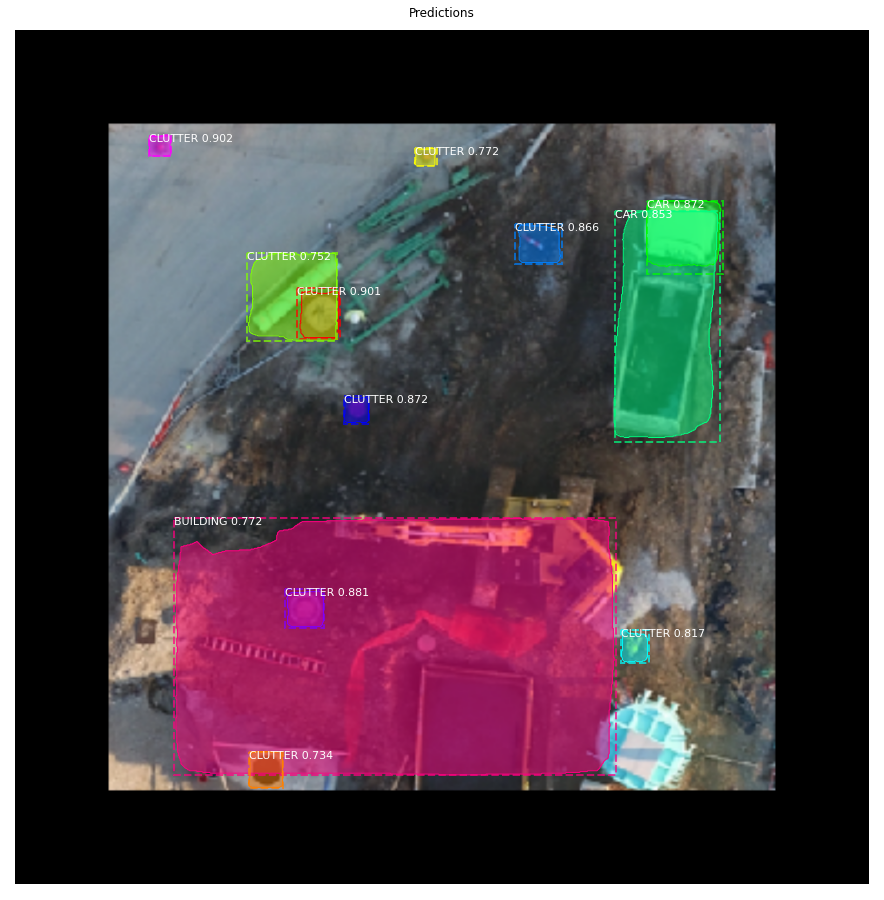

In [113]:
# select a random image to visualise object detection result
image_id = np.random.choice(test_set.image_ids, 1)[0] 
image, image_meta, gt_class_id, gt_bbox, gt_mask =    modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], 
                            title="Predictions")